## Sequence-to-Sequence Model for Machine Translation

In this assignment we will apply transformer-based model for machine translation.

We will use tools from `transformers`, `datasets` and `evaluate` libraries by HuggingFace.




In [1]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 788.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━

In [2]:

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data


Today there's a number of pretrained machine translation models for different languages. But in practice we could face a task of domain specific translation where general pretrained models sometimes fail to show good performance.

Let's try to fine-tune pretrained machine translation model on medical data. We will use PubMed dataset with English-French texts from `datasets` library.

In [3]:
from datasets import load_dataset

raw_datasets = load_dataset("qanastek/WMT-16-PubMed", lang1="en", lang2="fr")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for qanastek/WMT-16-PubMed contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/qanastek/WMT-16-PubMed
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `dataset

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 614093
    })
})

We will split the dataset into train and validation part.

In [5]:
split_datasets = raw_datasets["train"].train_test_split(train_size=0.8, seed=20)
split_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 491274
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 122819
    })
})

In [6]:
split_datasets["validation"] = split_datasets.pop("test")

### Tokenization

We will use transformer model `Helsinki-NLP/opus-mt-en-fr` pretrained for machine translation from English to French.

Transformer models use BPE tokenization and tokenizer is trained simultaneously with model training. So we need to load tokenizer from the pretrained model we are going to apply.

In [7]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Check the results of tokenization for some examples in English and in French.

In [8]:
text = 'Hyponatremia in the elderly: its role in the frailty'
tokenized = tokenizer(text)
tokenized

{'input_ids': [36619, 10484, 158, 27621, 18, 4, 13931, 37, 96, 908, 18, 4, 1231, 17465, 1744, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

To get tokens from the ids returned by tokenizer, we can use `convert_ids_to_tokens`.

In [9]:
print(tokenizer.convert_ids_to_tokens(tokenized['input_ids']))

['▁Hypo', 'nat', 're', 'mia', '▁in', '▁the', '▁elderly', ':', '▁its', '▁role', '▁in', '▁the', '▁f', 'rail', 'ty', '</s>']


In [10]:
text = "L'hyponatrémie du sujet âgé: implication dans la fragilité"
tokenized = tokenizer(text)

In [11]:
print(tokenizer.convert_ids_to_tokens(tokenized['input_ids']))

['▁L', "'", 'hy', 'pon', 'at', 'ré', 'mie', '▁du', '▁su', 'jet', '▁â', 'gé', ':', '▁implication', '▁dans', '▁la', '▁fra', 'g', 'il', 'ité', '</s>']


Note that French text was split into very short tokens as the tokenizer didn't recognize the target language. To tokenize target text correctly we need to pass it with the argument `text_target`.

In [12]:
text = "L'hyponatrémie du sujet âgé: implication dans la fragilité"
tokenized = tokenizer(text_target=text)

In [13]:
print(tokenizer.convert_ids_to_tokens(tokenized['input_ids']))

['▁L', "'", 'hypo', 'nat', 'r', 'émie', '▁du', '▁sujet', '▁âgé', ':', '▁implication', '▁dans', '▁la', '▁fragilité', '</s>']


**Task 1.**

*1 point*

Write function to preprocess dataset items using tokenizer, don't forget to use `text_target` for target texts.

We want to set maximum length for the texts and cut all the texts that appear to be longer. So apply a tokenizer with fixed maximum sequence length using `max_length` parameter and setting `truncation=True`. Taking arbitrary `max_length` is probably not the best idea. Look at the distribution of text lengths and choose it wisely.

In [14]:
split_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 491274
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 122819
    })
})

In [15]:
split_datasets['train'][0]

{'translation': {'en': 'Isolated glomus tumor of the left lower limb',
  'fr': 'Tumeur glomique isolée du membre inférieur gauche'}}

In [64]:
# examples -- dataset items
def preprocess_function(examples, max_length=32):
    english_texts = [ex['en'] for ex in examples['translation']]
    french_texts = [ex['fr'] for ex in examples['translation']]
    model_inputs = tokenizer(english_texts, max_length=max_length, truncation=True, padding=True, text_target=french_texts)

    return model_inputs

Create tokenized dataset by appling preprocessing function to `split_datasets` with `map` method. Set parameter `batched=True` to make computing faster.

In [75]:
tokenized_datasets = split_datasets.map(preprocess_function, batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 491274
    })
    validation: Dataset({
        features: ['translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 122819
    })
})

In [69]:
tokenized_datasets['train'][0]

{'translation': {'en': 'Isolated glomus tumor of the left lower limb',
  'fr': 'Tumeur glomique isolée du membre inférieur gauche'},
 'input_ids': [47,
  3790,
  2468,
  49,
  19073,
  6732,
  40086,
  7,
  4,
  1684,
  2803,
  33150,
  0,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'labels': [491,
  19219,
  954,
  376,
  24087,
  33692,
  22,
  1084,
  6792,
  4789,
  0,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513,
  59513]}

### Model

We can use the model for inference with the help of pipeline from `transformers` library. To initialize pipeline we need to pass task type (in our case `translation`) and model name.

In [19]:
from transformers import pipeline

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
translator = pipeline("translation", model=model_checkpoint)


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Take a look at some examples of translation by pretrained model.

In [20]:
translator("Clinical efficacy of eculizumab as treatment of gemcitabine-induced thrombotic microangiopathy: A case report")
# Efficacité de l'éculizumab comme traitement de la microangiopathie thrombotique induite par la gemcitabine : à propos d'un cas

[{'translation_text': "Efficacité clinique de l'eculizumab comme traitement de la microangiopathie thrombotique induite par la gemcitabine: rapport de cas"}]

In [21]:
translator("Proliferative verrucous leukoplakia: Three cases and literature review")
# Leucoplasie verruqueuse proliférative : trois observations et revue de la littérature

[{'translation_text': 'Verrucous leukoplakia proliférative : trois cas et revue de la littérature'}]

To fine-tune the model on our data we need to load it from pretrained checkpoint.

`transformers` library offers wide range of the models for various tasks (for example, `AutoModelForSequenceClassification`, `AutoModelForTokenClassification`, `AutoModelWithLMHead`). For the task of machine translation we will use `AutoModelForSeq2SeqLM` model.

In [22]:
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Take a look at the model's structure.

In [23]:
model

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

### Self-Attention

Let's get a closer look at the internals of transformer models.

Transformer models are based on self-attention mechanism.
An attention function aims to assess the relation between the elements of the sequence. The output for each element is computed as a weighted sum of the value vectors of other elements, where the weight for each value is computed by a score function for the query vector (for current element) with the corresponding key (for key-value pairs of other elements). Query, key and value vectors are computed multiplying embeddings by weight matrices $W_q$, $W_k$, $W_v$ that are trained during the model training.

$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$


**Task 2 (3 points)**. Implement self-attention mechanism.

1. Create random embedding tensor $X$ of dimension $[sequence\_length, emb\_dim]$, where $emb\_dim$ is the dimension of embedding layer in the pretrained model.
2. In `SelfAttention` class implement method `initialize_weights` to create random tensors of weights for queries, keys and values $w_q$, $w_k$, $w_v$ of dimension $[emb\_dim, dim_k]$ (dimension of query, key and value vector will be equal, let's set $dim_k = 64$).
3. In `SelfAttention` class implement method `forward` to calculate dot-product attention. The method should take embedding tensor $X$ as an input.
 - Compute $query$, $key$ and $value$ tensors multiplying embeddings by weights $w_q$, $w_k$, $w_v$ (the result tensors should have dimension $[sequence\_length, dim_k]$).
 - Take the dot product of the queries with keys.
 - Divide the obtaned result by the dimension of key vector.
 - Use softmax to get the attention weights.
 - Apply calculated attention weights to the values.

It's better to use just tensors, but if you're tempted to use `nn.Linear` instead, do `bias=False`.

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
  def __init__(self, seq_len, emb_dim, dim_k):
    super(SelfAttention, self).__init__()
    self.emb_dim = emb_dim
    self.dim_k = dim_k
    self.initialize_weights()

  def initialize_weights(self):
    self.w_q = nn.Parameter(torch.randn(self.emb_dim, self.dim_k))
    self.w_k = nn.Parameter(torch.randn(self.emb_dim, self.dim_k))
    self.w_v = nn.Parameter(torch.randn(self.emb_dim, self.dim_k))

  def forward(self, X):
    query = torch.matmul(X, self.w_q)
    key = torch.matmul(X, self.w_k)
    value = torch.matmul(X, self.w_v)

    # Dot product of query and key (transposed)
    scores = torch.matmul(query, key.transpose(-2, -1))

    # Scale scores by sqrt(dim_k) and apply softmax to get attention weights
    attn_weights = F.softmax(scores / (self.dim_k ** 0.5), dim=-1)

    # Apply attention weights to values
    output = torch.matmul(attn_weights, value)
    return output


In [25]:
# Set parameters
seq_len = 10  # Example sequence length
emb_dim = 128  # Example embedding dimension from a pretrained model
dim_k = 64  # Dimension of query, key, and value vectors

In [26]:
# create embedding tensor X
X = torch.randn(seq_len, emb_dim)

In [27]:
# initialize SelfAttention layer
self_attention = SelfAttention(seq_len, emb_dim, dim_k)

In [28]:
# calculate output for X
output = self_attention(X)
output.size()

torch.Size([10, 64])

### Attention Weights

Now let's check out attention weights of our pretrained model.

To access the attention weights we can run `generate` method using parameters `return_dict_in_generate` and `output_attentions`. Let's set `num_beams=1` and `do_sample=False` to apply simple greedy search decoding.

In [29]:
input_text = "Proliferative verrucous leukoplakia: Three cases and literature review"
input_ids = tokenizer.encode(input_text, return_tensors='pt')  # tokenize input text
print(len(input_ids[0]))
outputs = model.generate(input_ids, return_dict_in_generate=True, output_attentions=True, num_beams=1, do_sample=False)


21


In [30]:
print(type(outputs))

<class 'transformers.generation.utils.GenerateEncoderDecoderOutput'>


`generate` methods returns dict with predicted tokens, and attention values including encoder, decoder and encoder-decoder attention weights.

In [31]:
outputs.keys()

odict_keys(['sequences', 'encoder_attentions', 'decoder_attentions', 'cross_attentions', 'past_key_values'])

In [32]:
print(tokenizer.convert_ids_to_tokens(outputs["sequences"][0]))
gen_len = len(outputs["sequences"][0])
print(f"generated length: {gen_len}")

['<pad>', '▁Ver', 'ru', 'cou', 's', '▁le', 'uk', 'op', 'la', 'ki', 'a', '▁pro', 'l', 'if', 'ér', 'ative', '▁:', '▁trois', '▁cas', '▁et', '▁revue', '▁de', '▁la', '▁littérature', '</s>']
generated length: 25


Let's look into cross attentions to get the idea how input tokens affect each of the predicted tokens.

Each element of `cross_attentions` object contains attention weights for a single generated token. Attention weights for each generated token have tensors of weights for each decoder layer. Attention weights tensor for a single layer has a shape [batch size, number of attention heads, generated sequence length, input sequence length]. As the tensor corresponds to a single generated token, generated sequence length equals 1.

In [33]:
# one element for each generated output sequence
len(outputs['cross_attentions']) # number of generated tokens

24

In [34]:
# one element for each layer of the decoder
len(outputs['cross_attentions'][0]) # for generated token of index 0 we have (number below) layers

6

In [35]:
# batch_size, num_heads, generated_length, sequence_length
outputs['cross_attentions'][0][0].size() # for each token, for each layer we have batch size 1, 8 heads of attention, 1 generated token (because attentions marked by single gen token, see len(outputs['cross_attentions'])), and finally 21 input tokens

torch.Size([1, 8, 1, 21])

**Task 3.**

*3 points*

Write code to build a tensor of cross-attention weights with size `[generated_length, input_sequence]` for a fixed attention head and fixed decoder layer (let's take last layer).

In [36]:
# input_ids -- tensor of input tokens ids
# outputs -- output of generate method
# attn_head_id -- number of attention head
# decoder_layer_id -- number of decoder layer

import torch
import seaborn as sns
import matplotlib.pyplot as plt

def build_attn(input_ids, outputs, attn_head_id, decoder_layer_id):
  attn_weights = []
  # Iterate over each generated token's attention weights
  for step_attention in outputs.cross_attentions:
      # step_attention has shape [num_layers, batch_size, num_heads, gen_seq_len, input_seq_len]

      # Select attention for the specified layer and head
      # We use decoder_layer_id to select the layer, and attn_head_id to select the attention head
      # Since we're interested in a specific layer, and the generated sequence length is 1,
      # the resulting shape will be [batch size, 1, input sequence length]
      selected_attn = step_attention[decoder_layer_id][:, attn_head_id, :, :]

      # Append the selected attention weights to the list
      attn_weights.append(selected_attn.squeeze(1))  # Remove the gen_seq_len dimension since it's 1

  # Concatenate the list of tensors along the new dimension to get the final tensor
  # The final shape will be [generated_length, input_sequence_length]
  attn_tensor = torch.cat(attn_weights, dim=0)
  return attn_tensor



def visualize_attn_weights(attn_tensor):
    plt.figure(figsize=(15, 13))
    sns.heatmap(attn_tensor.cpu().detach().numpy(), annot=True, cmap='viridis')
    plt.xlabel('Input Sequence Tokens')
    plt.ylabel('Generated Sequence Tokens')
    plt.title('Cross-Attention Weights')
    plt.show()

Visualize this tensor of cross-attention weights using heatmap to see the relation between input and output tokens.

Try the visualization for different input texts and analyze the results.

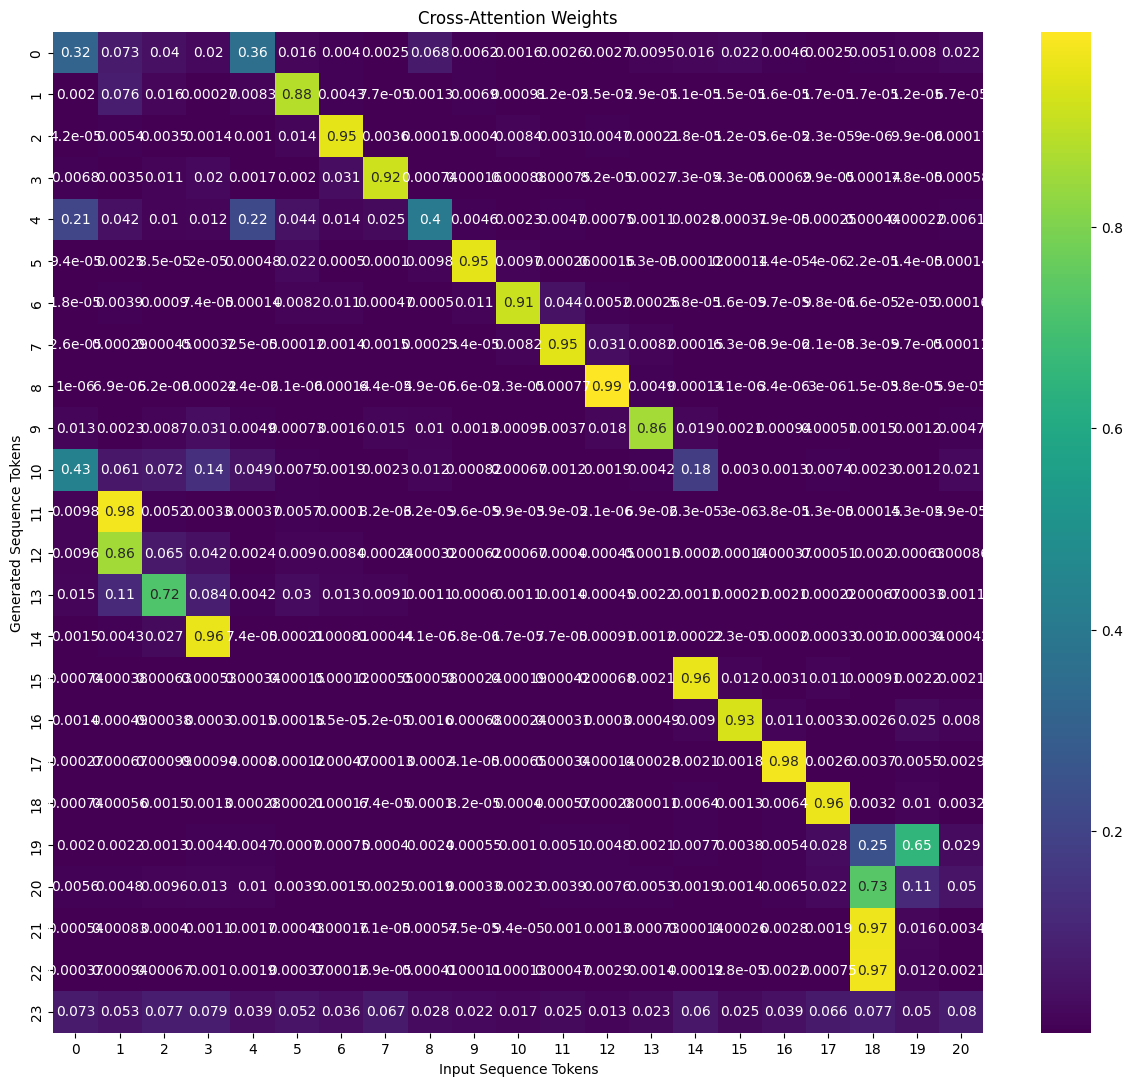

In [37]:
attn_head_id = 0 # head number 0 (from 0 to 8)
decoder_layer_id = len(outputs['cross_attentions'][0]) - 1 # last layer
if 'cross_attentions' in outputs:
    attn_tensor = build_attn(input_ids, outputs, attn_head_id, decoder_layer_id)
    visualize_attn_weights(attn_tensor)

### Positional Encodings

Now let's take a look at embeddings and positional encodings that are used in transformer models. As we can see from the structure of our pretrained model, it uses sinusoidal position embeddings.

In [38]:
model # MarianSinusoidalPositionalEmbedding

MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(59514, 512, padding_idx=59513)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(59514, 512, padding_idx=59513)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

**Task 4.**

*1 point*

Check the encoder embeddings and their shape applying embedding layer to ids of input tokens.

In [39]:
embed_tokens = model.model.encoder.embed_tokens
encoder_embeddings = embed_tokens(input_ids)  # Apply embedding layer to input token IDs
encoder_embeddings_shape = encoder_embeddings.shape
encoder_embeddings_shape # batch size 1, input len 21, 512 embed vector length

torch.Size([1, 21, 512])

Get positional encodings applying its layer to the shape of input tensor.

In [46]:
positional_encodings = model.model.encoder.embed_positions(input_ids.shape) # expected torch.Size
positional_encodings.size()

torch.Size([21, 512])

Visualize obtained positional encodings using heatmap.

(512, 21)


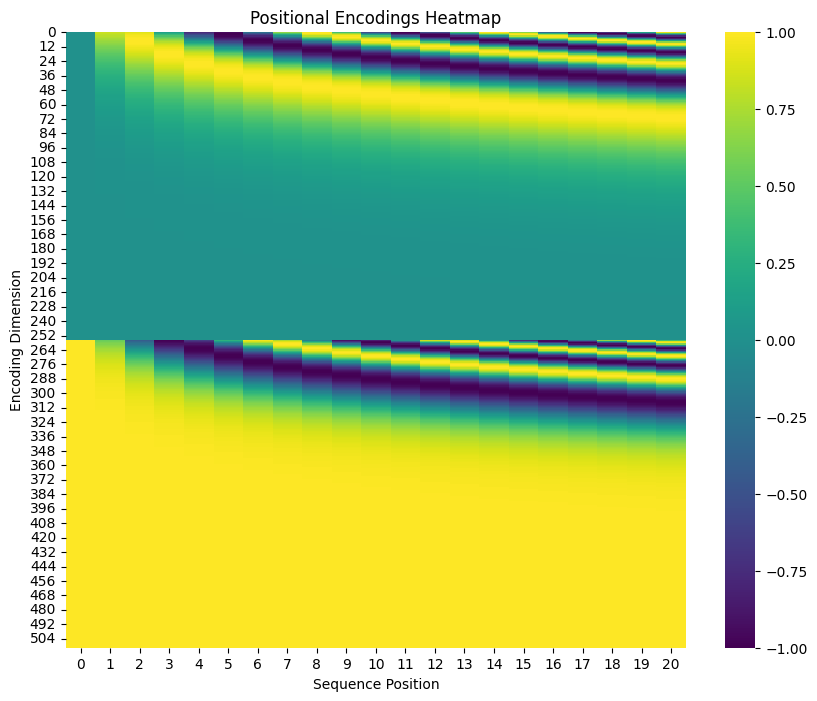

In [51]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

positional_encodings_np = positional_encodings.detach().cpu().numpy()
positional_encodings_to_visualize = positional_encodings_np.T
print(positional_encodings_to_visualize.shape)

# Visualize the positional encodings using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(positional_encodings_to_visualize, annot=False, cmap='viridis')
plt.title('Positional Encodings Heatmap')
plt.xlabel('Sequence Position')
plt.ylabel('Encoding Dimension')
plt.show()
# https://github.com/gucci-j/pe-visualization

### Training

Now we can move on to fine-tuning of the pretrained model on our data. First let's create data collator to form batches with padding to maximum length of sequence within a batch.

In [52]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [79]:
def remove_translation(example):
    return {
        'input_ids': example['input_ids'],
        'attention_mask': example['attention_mask'],
        'labels': example['labels']
    }

tokenized_datasets['train'] = tokenized_datasets['train'].map(remove_translation, remove_columns=['translation'])
tokenized_datasets['validation'] = tokenized_datasets['validation'].map(remove_translation, remove_columns=['translation'])

Map:   0%|          | 0/491274 [00:00<?, ? examples/s]

Map:   0%|          | 0/122819 [00:00<?, ? examples/s]

In [80]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(0, 3)])
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'decoder_input_ids'])

In [81]:
batch["labels"]

tensor([[  491, 19219,   954,   376, 24087, 33692,    22,  1084,  6792,  4789,
             0, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513],
        [   89,  8283, 11724,  3368,  2009,  2558,  8605,    87,     6, 11699,
           150,  2558,  7605, 11396, 18113, 23411,  3495,     0, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513],
        [   60, 14800, 15093,  3994,    78,    17,  1833,    20,     6,   112,
          6517,    17,  1612, 13147, 12149,     0, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513]])

In [82]:
batch["decoder_input_ids"]

tensor([[59513,   491, 19219,   954,   376, 24087, 33692,    22,  1084,  6792,
          4789,     0, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513],
        [59513,    89,  8283, 11724,  3368,  2009,  2558,  8605,    87,     6,
         11699,   150,  2558,  7605, 11396, 18113, 23411,  3495,     0, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513],
        [59513,    60, 14800, 15093,  3994,    78,    17,  1833,    20,     6,
           112,  6517,    17,  1612, 13147, 12149,     0, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513,
         59513, 59513]])

In [83]:
for i in range(3):
    print(tokenized_datasets["train"][i]["labels"])

[491, 19219, 954, 376, 24087, 33692, 22, 1084, 6792, 4789, 0, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513]
[89, 8283, 11724, 3368, 2009, 2558, 8605, 87, 6, 11699, 150, 2558, 7605, 11396, 18113, 23411, 3495, 0, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513]
[60, 14800, 15093, 3994, 78, 17, 1833, 20, 6, 112, 6517, 17, 1612, 13147, 12149, 0, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513, 59513]


We will perform training cycle using `Trainer` object. Trainer requires `TrainingArguments` with all parameters that will be used for training including learning rate, batch size for traning and evaluation, weight decay etc.

In [84]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    f"mt-en-fr-med",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
)

During evaluation step on a training process the trainer can compute additional metrics apart from calculating loss. To enable it we will define `compute_metrics` function with BLEU calculation.

In [85]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 1.2 MB/s eta 0:00:00


In [86]:
import evaluate
metric = evaluate.load("sacrebleu")

Let's see what the metric returns.

In [87]:
predictions = [
    "Clinical performance of eculizumab treatment for thrombotic microangiopathy induced by gemcitabine: a case study"
]
references = [
    [
        "Clinical efficacy of eculizumab as treatment of gemcitabine-induced thrombotic microangiopathy: a case report"
    ]
]
metric.compute(predictions=predictions, references=references)

{'score': 15.310245441182436,
 'counts': [9, 4, 1, 0],
 'totals': [15, 14, 13, 12],
 'precisions': [60.0,
  28.571428571428573,
  7.6923076923076925,
  4.166666666666667],
 'bp': 1.0,
 'sys_len': 15,
 'ref_len': 14}

Now we can implement `compute_metrics` function. Note that since tokenizer can return special tokens (as `<s>` in the end of sequence), we want to take it into account and ignore these tokens for metrics calculation. Special tokens correspond to -100 in labels so we will replace them with padding token id.

In [88]:
import numpy as np

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # in case the model returns not only prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # replace labels with -100 to padding
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

Let's define training and validation datasets. The original dataset is quite big and training and evaluation will take quite a long time so you can run training on limited subset of the original data.

In [102]:

train_subset_size = 20000
val_subset_size = 4000

train_indices = np.random.permutation(len(tokenized_datasets['train']))[:train_subset_size]
val_indices = np.random.permutation(len(tokenized_datasets['validation']))[:val_subset_size]


In [103]:
train_dataset = tokenized_datasets['train'].select(train_indices)

In [104]:
val_dataset = tokenized_datasets['validation'].select(val_indices)

Now we can create trainer passing the model, training arguments, training dataset, validation dataset, data collator, tokenizer and compute metrics function.

In [95]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


**Task 5.**

*2 points*

Run evaluation of pretrained model using `evaluate` method of trainer to evaluate the model's performance before fine-tuning.

Then run training with `train` method and evaluate fine-tuned model.

Try to take a not too small sample of data for fine tuning. Training on around 10k examples could be ok.

In [96]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 3.8581767082214355, 'eval_bleu': 35.135151500574516, 'eval_runtime': 76.0186, 'eval_samples_per_second': 26.309, 'eval_steps_per_second': 0.421}


In [97]:
trainer.train()

Step,Training Loss
500,0.827700


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}


Step,Training Loss
500,0.827700


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}


TrainOutput(global_step=939, training_loss=0.7519312524440063, metrics={'train_runtime': 125.7645, 'train_samples_per_second': 238.541, 'train_steps_per_second': 7.466, 'total_flos': 254237736960000.0, 'train_loss': 0.7519312524440063, 'epoch': 3.0})

In [98]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.7081818580627441, 'eval_bleu': 41.05669657270966, 'eval_runtime': 73.8664, 'eval_samples_per_second': 27.076, 'eval_steps_per_second': 0.433, 'epoch': 3.0}


Check the inference of the model on some examples using pipeline and analyze if the results are different after fine-tuning.

In [107]:
examples = ["Clinical efficacy of eculizumab as treatment of gemcitabine-induced thrombotic microangiopathy: A case report",
            "Proliferative verrucous leukoplakia: Three cases and literature review"]
# Efficacité de l'éculizumab comme traitement de la microangiopathie thrombotique induite par la gemcitabine : à propos d'un cas
# Leucoplasie verruqueuse proliférative : trois observations et revue de la littérature

translations = [translator(example) for example in examples]

# Print out translations
for example, translation in zip(examples, translations):
    print(f"Original:\n{example}\n\nTranslated:\n{translation[0]['translation_text']}\n")

Original:
Clinical efficacy of eculizumab as treatment of gemcitabine-induced thrombotic microangiopathy: A case report

Translated:
Efficacité clinique de l'eculizumab comme traitement de la microangiopathie thrombotique induite par la gemcitabine: rapport de cas

Original:
Proliferative verrucous leukoplakia: Three cases and literature review

Translated:
Verrucous leukoplakia proliférative : trois cas et revue de la littérature

